# Imports

In [359]:
#Basic imports 
import csv
import pandas as pd
import numpy as np
from numpy import int32
import string
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from nltk import text
from keras.models import Sequential
from keras import layers
from keras.layers import LeakyReLU
import pickle
keras = tf.keras 
from sklearn.model_selection import train_test_split

#Removal of stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

#Stemming the words
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

#For vectorizing text
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf

#Resampling imports
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

#Packages for CNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#Importing packages for RNN-LSTM model 
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import seaborn as sns
%matplotlib inline

#Filter Warnings
import warnings as wrn
wrn.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preperation

In [329]:
df = pd.read_csv("politicalLean.csv",index_col=0)
df =df.reset_index()
print("Total Number of Rows in dataset: " + str(len(df.index)))
print("---")
print(df.isnull().sum())
#Selecting only the title and political leaning for classification
df = df[['Title', 'Political Lean']]
print("---")
print(df['Title'].map(lambda x: len(x)).max())
print("---")
print(df.isnull().sum())


Total Number of Rows in dataset: 12854
---
Title                  0
Political Lean         0
Score                  0
Id                     0
Subreddit              0
URL                    0
Num of Comments        0
Text               10426
Date Created           0
dtype: int64
---
300
---
Title             0
Political Lean    0
dtype: int64


## Function Creation

In [228]:
def dataPrep(dataframe, lower):
  #Checking for null values
  

  dataframe.loc[df['Political Lean'] == "Liberal", 'Political Lean'] = 0
  dataframe.loc[df['Political Lean'] == "Conservative", 'Political Lean'] = 1

  #Removing Stopwords, punctuation and moving all letters to lowercase
  dataframe['Title'] = dataframe['Title'].apply(lambda x:x.translate(str.maketrans('', '',string.punctuation)))
  dataframe['Title'] = dataframe['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  if lower == 1:
    dataframe['Title'] = dataframe['Title'].apply(lambda x:x.lower())
  #else:  
    #print(dataframe['Title'][0])
    #dataframe['Title'] = dataframe['Title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    #print(dataframe['Title'][0])
    #dataframe['Title'] = dataframe['Title'].apply(lambda x: [stemmer.stem(y) for y in x])
    #print(dataframe['Title'][0])
  X = dataframe['Title']

  y = dataframe['Political Lean']
  y = np.asarray(y).astype('float32')
  return(X, y)

In [4]:
#Creating a function for plotting ouput data of model later
def plotCheck(history):
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()



In [5]:
def prediction_Output(predictions):
  prediction_res = np.mean(predictions) 
  if prediction_res < .5:
    prediction = "Likely Written by a Liberal"
  else:
    prediction = "Likely Written by a Republican"
  return prediction

In [6]:
df.value_counts('Political Lean')

Political Lean
Liberal         8319
Conservative    4535
dtype: int64

In [7]:
X, y = dataPrep(df, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

df['Title'][0]

'no matter who someone is how they look like what language they speak what they wear remember the human for the sake of humanity the working class can and must unite across all arbitrary boundaries'

Undersampling to reduce Computational Cost 

In [8]:
def underSamp(X_train, X_test, y_train, y_test, model):
  X_train1 = X_train.to_numpy()
  X_test1 = X_test.to_numpy()

  under_sampler = RandomUnderSampler(random_state=420)
  X1 = X_train1.reshape(-1, 1)
  y1 = y_train.reshape(-1, 1)
  X_test1 = X_test1.reshape(-1, 1)
  y_test1 = y_test.reshape(-1, 1)

  X_under, y_train_under = under_sampler.fit_resample(X1, y1)
  X_test_under, y_test_under = under_sampler.fit_resample(X_test1, y_test1)
  if model == 'CNN':
    X_under = X_under.tolist()
    X_test_under = X_test_under.tolist()
    

  print(f"Training target statistics: {Counter(y_train_under)}")
  print(f"Testing target statistics: {Counter(y_test_under)}")
  return X_under, y_train_under, X_test_under, y_test_under

In [9]:
def overSamp(X_train, X_test, y_train, y_test, model):
  X_train1 = X_train.to_numpy()
  X_test1 = X_test.to_numpy()

  over_sampler = RandomOverSampler(random_state=420)
  X1 = X_train1.reshape(-1, 1)
  y1 = y_train.reshape(-1, 1)
  X_test1 = X_test1.reshape(-1, 1)
  y_test1 = y_test.reshape(-1, 1)

  X_over, y_train_over = over_sampler.fit_resample(X1, y1)
  X_test_over, y_test_over = over_sampler.fit_resample(X_test1, y_test1)
  if model == 'CNN':
    X_over = X_over.tolist()
    X_test_over = X_test_over.tolist()
    

  print(f"Training target statistics: {Counter(y_train_over)}")
  print(f"Testing target statistics: {Counter(y_test_over)}")
  return X_over, y_train_over, X_test_over, y_test_over

In [186]:
X_under, y_train_under, X_test_under, y_test_under = underSamp(X_train, X_test, y_train, y_test, 'ANN')
X_test_under[0:5]

Training target statistics: Counter({0.0: 3376, 1.0: 3376})
Testing target statistics: Counter({0.0: 1159, 1.0: 1159})


array([['28 young people and faith leaders hunger striking for democracy reform are arrested outside us capitol'],
       ['germany agrees to axe nord stream 2 if russia invades ukraine'],
       ['‘held hostage’ how critical race theory moved from fox news to school boards  in towns nationwide wellconnected conservative activists and fox news have ramped up the tension in fights over race and equity in schools'],
       ['gopuff workers strike at one of the startups busiest warehouses'],
       ['a great article i found online on the background and cause of the bengal famine of 1943 its a shame that so many people refuse to acknowledge the horrors of manmade massstarvation when they are caused by british imperialism and capitalism instead of stalinist socialism']],
      dtype=object)

# ANN MODEL

In [350]:
#Preparing the data for transformation into vectorized data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

X_under, y_train_under, X_test_under, y_test_under = underSamp(X_train, X_test, y_train, y_test, 'ANN')

#X_over, y_train_over, X_test_over, y_test_over = overSamp(X_train, X_test, y_train, y_test, 'ANN')

X_under =X_under.flatten(order='C')
X_under = pd.Series(X_under)

X_test_under =X_test_under.flatten(order='C')
X_test_under = pd.Series(X_test_under)

#Count Vectorization fitting
count_vect = CountVectorizer()
count_vect.fit(X_under)

#Bigram vecotrization fitting
bigram_vectorizer = CountVectorizer(ngram_range=(1, 3), token_pattern=r'\b\w+\b', min_df=1)
bigram_vectorizer.fit(X_under)

#Creating the sparse matrix's from this data
X_train_COUNT = count_vect.transform(X_under)
X_test_COUNT  = count_vect.transform(X_test_under)

X_train_BIGRAM = bigram_vectorizer.transform(X_under)
X_test_BIGRAM = bigram_vectorizer.transform(X_test_under)


Training target statistics: Counter({0.0: 3376, 1.0: 3376})
Testing target statistics: Counter({0.0: 1159, 1.0: 1159})


In [351]:

textVec = X_train_BIGRAM
textVec_test = X_test_BIGRAM

input_dim = textVec.shape[1]  # Number of features
#input_dim = X_train_COUNT.shape[1] 

model_ANN = Sequential()
model_ANN.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
#model.add(layers.Dense(10, input_dim=65420, activation='sigmoid'))
model_ANN.add(layers.Dense(1, activation='sigmoid'))

In [352]:
model_ANN.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model_ANN.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 10)                1050070   
                                                                 
 dense_116 (Dense)           (None, 1)                 11        
                                                                 
Total params: 1,050,081
Trainable params: 1,050,081
Non-trainable params: 0
_________________________________________________________________


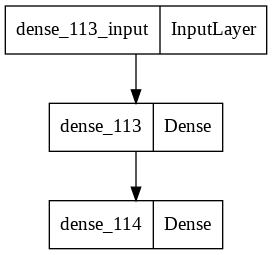

In [339]:
tf.keras.utils.plot_model(model_ANN)

In [356]:
history = model_ANN.fit(textVec, y_train_under,
                    #validation_split=0.33,
                    epochs=4,
                    verbose=False,
                    validation_data=(textVec_test, y_test_under),
                    batch_size=100)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


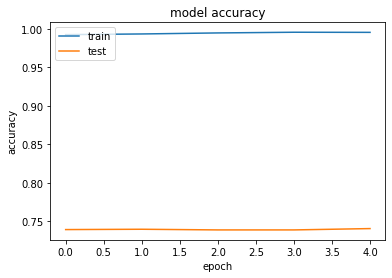

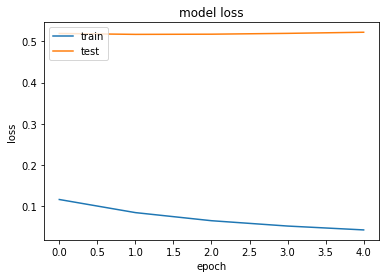

Training Accuracy: 0.9967
Testing Accuracy:  0.7407


In [357]:
plotCheck(history)

#Checking general accuracy of the model after training 
loss, accuracy1 = model_ANN.evaluate(textVec, y_train_under, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy1))

loss, accuracy2 = model_ANN.evaluate(textVec_test, y_test_under, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy2))

## Prediction:
ANN model

In [235]:
pred_Lib = "Voting machine maker wins appeal in GOP election inquiry"
pred_Con = "Bill Barr Urges Republicans to Pick an ‘Impressive’ and ‘Younger’ 2024 Nominee Instead of Trump"
pred_Con2 = 'After a lot of research, it appears that their excuse for this is closing the income and generational wealth gap between whites, minorities and “undocumented migrants”'

for i in [pred_Lib, pred_Con, pred_Con2]:
  tokenized_ann = i.split(" ")
  X_pred_bi = bigram_vectorizer.transform(tokenized_ann)
  predictions = model_ANN.predict(X_pred_bi)

  print(prediction_Output(predictions))


Likely Written by a Liberal
Likely Written by a Republican
Likely Written by a Republican


# CNN Model

In [368]:
X, y = dataPrep(df, 0)
scaler = MinMaxScaler(feature_range=(0, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
#X_under_CNN, y_train_under, X_test_under_CNN, y_test_under = underSamp(X_train, X_test, y_train, y_test, 'CNN')
#X_over, y_train_over, X_test_over, y_test_over = overSamp(X_train,X_test,y_train,y_test, 'CNN')

tokenizer = Tokenizer(num_words=300, lower=False)
tokenizer.fit_on_texts(X_train)


#tokenizer.fit_on_texts(X_train)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_test1= tokenizer.texts_to_sequences(X_test)


In [369]:
input_dim = len(tokenizer.word_index) + 1
embedding_dim = 50
maxlen = 30

X_train_CNN = pad_sequences(X_train1, padding='pre', maxlen=maxlen)
X_test_CNN = pad_sequences(X_test1, padding='pre', maxlen=maxlen)

X_train_CNN = scaler.fit_transform(X_train_CNN)
X_test_CNN = scaler.fit_transform(X_test_CNN)

In [370]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model_CNN = Sequential()
model_CNN.add(layers.Embedding(input_dim=input_dim, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_CNN.add(layers.Dense(20, activation='sigmoid'))
model_CNN.add(Dropout(0.5))
model_CNN.add(layers.Flatten(data_format = None))
model_CNN.add(layers.Dense(20, activation='sigmoid'))
model_CNN.add(layers.Dense(1, activation='sigmoid'))

model_CNN.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_CNN.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 30, 50)            1056350   
                                                                 
 dense_123 (Dense)           (None, 30, 20)            1020      
                                                                 
 dropout_37 (Dropout)        (None, 30, 20)            0         
                                                                 
 flatten_46 (Flatten)        (None, 600)               0         
                                                                 
 dense_124 (Dense)           (None, 20)                12020     
                                                                 
 dense_125 (Dense)           (None, 1)                 21        
                                                                 
Total params: 1,069,411
Trainable params: 1,069,411
N

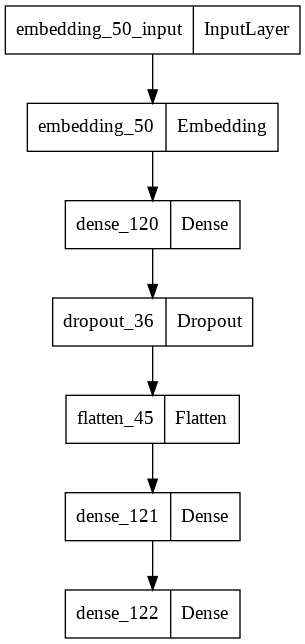

In [364]:
tf.keras.utils.plot_model(model_CNN)

In [372]:
history = model_CNN.fit(X_train_CNN, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test_CNN, y_test),
                    batch_size=100)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


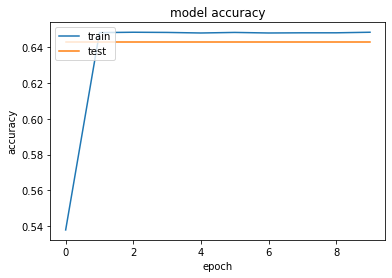

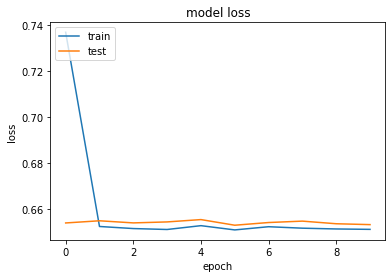

Training Accuracy: 0.6485
Testing Accuracy:  0.6431


In [373]:
plotCheck(history)

loss, accuracy = model_CNN.evaluate(X_train_CNN, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_CNN.evaluate(X_test_CNN, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

## Prediction:

CNN Model

In [257]:
pred_Lib = "Voting machine maker wins appeal in GOP election inquiry"
pred_Con = "Bill Barr Urges Republicans to Pick an ‘Impressive’ and ‘Younger’ 2024 Nominee Instead of Trump"
pred_Con2 = 'After a lot of research, it appears that their excuse for this is closing the income and generational wealth gap between whites, minorities and “undocumented migrants”'

for i in [pred_Lib, pred_Con, pred_Con2]:
  X_train1 = tokenizer.texts_to_sequences(i)
  X_pred_cnn = pad_sequences(X_train1, padding='post', maxlen=maxlen)
  predictions = model_CNN.predict(X_pred_cnn)
  #predictions = predictions.reshape(1, 1)
  #predictions = scaler.inverse_transform(np.mean(predictions))
  
  print(predictions[0])
  print(prediction_Output(predictions))

[0.4999752]
Likely Written by a Liberal
[0.4999752]
Likely Written by a Liberal
[0.4999752]
Likely Written by a Liberal


# LSTM Model: 

In [312]:
X, y = dataPrep(df, 0)



In [313]:
le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1,1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=40)

X_over, y_train_over, X_test_over, y_test_over = overSamp(X_train,X_test,y_train,y_test, 'CNN')


Training target statistics: Counter({1: 6269, 0: 6269})
Testing target statistics: Counter({0: 2050, 1: 2050})


In [367]:
max_words = 300
max_len = 150

textVec_LSTM = X_train
textVec_LSTM_test = X_test
y_train_textVec = y_train
y_test_textVec = y_test

token = Tokenizer(num_words=max_words)
token.fit_on_texts(textVec_LSTM)

sequences = token.texts_to_sequences(textVec_LSTM)
X_train_LSTM = sequence.pad_sequences(sequences,maxlen=max_len)

test_sequences = token.texts_to_sequences(textVec_LSTM_test)
X_test_LSTM = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [315]:
X_test_LSTM

array([[  0,   0,   0, ..., 207,  92,  82],
       [  0,   0,   0, ...,  12,  25, 255],
       [  0,   0,   0, ..., 546, 921, 789],
       ...,
       [  0,   0,   0, ..., 173,  12, 430],
       [  0,   0,   0, ..., 122, 996,   2],
       [  0,   0,   0, ..., 101,  61,  53]], dtype=int32)

In [316]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [317]:
model_LSTM = RNN()
model_LSTM.summary()
model_LSTM.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_46 (Embedding)    (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

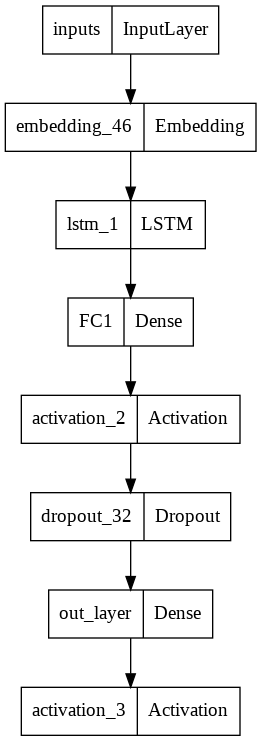

In [318]:
tf.keras.utils.plot_model(model_LSTM)

In [319]:
history = model_LSTM.fit(X_train_LSTM,
                    y_train_textVec,
                    batch_size=100,
                    epochs=30,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             min_delta=0.0001)])


Epoch 1/30
78/78 [==============================] - 16s 170ms/step - loss: 0.6286 - accuracy: 0.6627 - val_loss: 0.5586 - val_accuracy: 0.7318
Epoch 2/30
78/78 [==============================] - 13s 164ms/step - loss: 0.5253 - accuracy: 0.7434 - val_loss: 0.5330 - val_accuracy: 0.7355


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


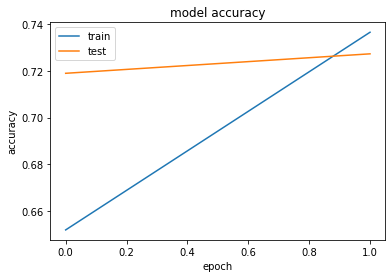

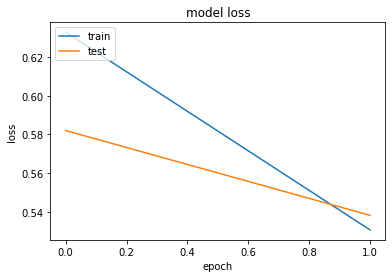

Training Accuracy: 0.7620
Testing Accuracy:  0.7296


In [169]:
plotCheck(history)

loss, accuracy = model_LSTM.evaluate(X_train_LSTM, y_train_textVec, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_LSTM.evaluate(X_test_LSTM, y_test_textVec, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

## Prediction:
LSTM Model

In [171]:
pred_Lib = "Voting machine maker wins appeal in GOP election inquiry"
pred_Con = "Bill Barr Urges Republicans to Pick an ‘Impressive’ and ‘Younger’ 2024 Nominee Instead of Trump"
pred_Con2 = 'After a lot of research, it appears that their excuse for this is closing the income and generational wealth gap between whites, minorities and “undocumented migrants”'

for i in [pred_Lib, pred_Con, pred_Con2]:
  test_sequences_Pred = token.texts_to_sequences(i)
  test_sequences_matrix = sequence.pad_sequences(test_sequences_Pred,maxlen=150)

  predictions = model_LSTM.predict([test_sequences_matrix])

  print(prediction_Output(predictions))




Likely Written by a Liberal
Likely Written by a Liberal
Likely Written by a Liberal


In [48]:
test_sequences_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

# Final Artifact:


In [360]:
filename = 'finalized_model_ANN.sav'
pickle.dump(model_ANN, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://0e251571-fc5b-43fa-95f5-4c8ebaf5d619/assets
